In [ ]:
#conecting drive to this note book

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing Libraries
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import zipfile

#this part is for TPU incase of using not in this code it better to use gpu because of the import of images
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
#A parameter that will guide the tf. Data runtime to set the value dynamically at runtime.
AUTOTUNE = tf.data.AUTOTUNE
#Batch size (group) 25 images
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
#A parameter that defines whether there is inflammation - "pneumonia" or not - "normal".
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [ ]:


# Replace with the name of your uploaded zip file
zip_path = '/content/drive/MyDrive/ChestXrayoutput.zip'

# Unzipping the dataset into a directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ChestXrayoutput')


In [ ]:

def get_label(file_path):
    # the file path structure is .../<class-name>/...
    parts = tf.strings.split(file_path, os.path.sep)
    # Returns a boolean: True for 'PNEUMONIA', False otherwise
    return tf.equal(parts[-2], "PNEUMONIA")

def process_path(file_path):
    label = get_label(file_path)
    # Print file path and label - only for debugging, should be removed for actual training
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# decode_img if needed
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [180, 180])
    return img

# Process the training dataset
train_list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/ChestXrayoutput/ChestXrayoutput/train/*/*', shuffle=False)
ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
print("Train dataset size:", tf.data.experimental.cardinality(ds).numpy())


# Process the testing dataset
test_list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/ChestXrayoutput/ChestXrayoutput/test/*/*', shuffle=False)
test_ds = test_list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print("test dataset size:", tf.data.experimental.cardinality(test_ds).numpy())

Train dataset size: 5232
test dataset size: 25


In [ ]:
#creating validtion and traning set (80% tranig , 20% validtion)
#shuffling the imgae for less bias
ds = ds.shuffle(10000)
#taking 4200 images after shuffling
train_ds = ds.take(4200)
#skips 4200 imahes and take all the rest for validtion
val_ds = ds.skip(4200)

#printing
print("Train dataset size:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation dataset size:", tf.data.experimental.cardinality(val_ds).numpy())


Train dataset size: 4200
Validation dataset size: 1032


In [ ]:
#An example of an image pair and a corresponding label of the first image in the training set.(false = normal)
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 1)
Label:  False


In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
#called for the next iteration of training data. An Iterator in Python is an object used to iterate over objects.
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
#creating plots to show the images from the data
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

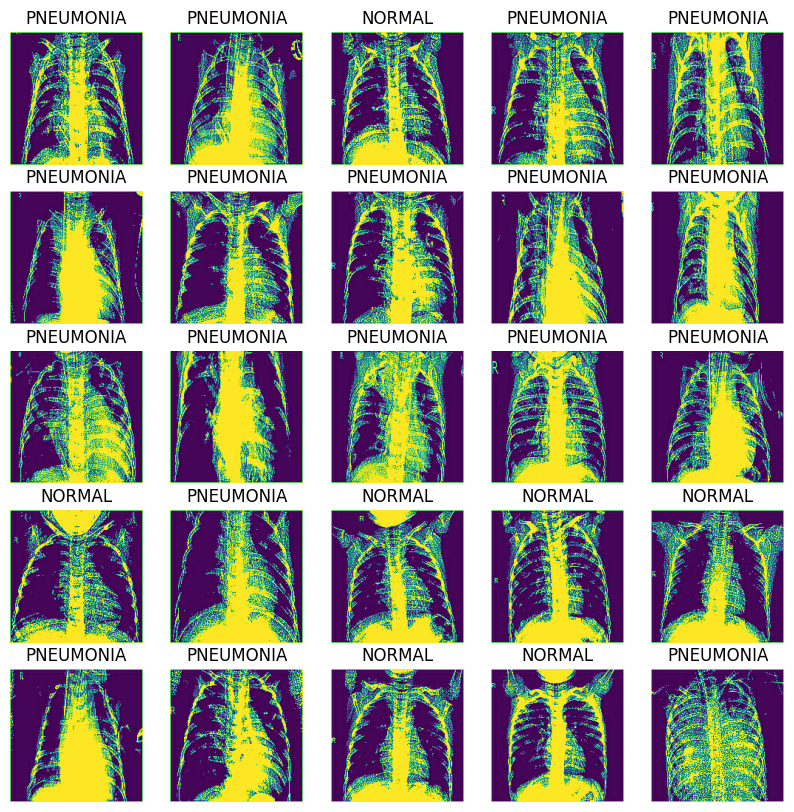

In [ ]:
#showing the plot
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models, Input

#building helper function for easyer CNN creation (blocks)

#These two functions are used to create the building blocks of the convolution network in our model.
#The conv_block is used to stack a large number of convolutional layers to extract features from the input image.
#The dense_block is used to create fully connected layers for classification/regression tasks.
#These building blocks are combined together to form the final architecture of the .CNN

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs

def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

# This function defines a Transformer Encoder Layer with normalization, multi-head self-attention, and a feed-forward network.
def TransformerEncoderLayer(inputs, num_heads, ff_dim):
      # Normalization and Attention
      x = layers.LayerNormalization(epsilon=1e-6)(inputs)
      x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim, dropout=0.1)(x, x)
      x = layers.Dropout(0.1)(x)
      res = x + inputs

      # Feed Forward Part
      x = layers.LayerNormalization(epsilon=1e-6)(res)
      x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
      return x + res

In [ ]:


def build_model():
    #Input Layer: Receives X-ray images with dimensions (height, width, 1) - 1 chnnel for fray scale
    inputs = keras.Input(shape=(180, 180, 1))

    #Rescaling Layer: Scales pixel values to a 0-1 range by dividing by 255, normalizing the input data.
    x = layers.Rescaling(1.0 / 255)(inputs)

    #Convolution Layers:
    #Two initial convolution layers each with 16 (3x3) filters use ReLU activation and 'same' padding,
    #producing feature maps from the input and then from each other's outputs.
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)

    #MaxPooling Layer: Reduces feature map dimensions by taking the maximum value in 2x2 areas, focusing on prominent features.
    x = layers.MaxPool2D()(x)

    #Convolution Block Layers:
    #Four blocks, each comprising two Separable Convolution layers with increasing filter sizes (32, 64, 128, 256), ReLU activation, 'same' padding,
    #followed by batch normalization.
    #The third and fourth blocks include dropout layers with rates of 0.2 to reduce overfitting.
    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    # Preparing for Transformer
    x = layers.Flatten()(x)  # Flatten instead to preserve feature dimensions
    x = layers.Reshape((-1, x.shape[-1]))(x)  # Prepare for Transformer

    # Transformer Encoder
    x = TransformerEncoderLayer(x, num_heads=6, ff_dim=128)

    # Since the output of transformer_encoder is already 2D (batch, features), we skip GlobalAveragePooling1D
    #Flatten Layer: Converts the final block's output into a one-dimensional vector for dense processing.
    x = layers.Flatten()(x)  # Ensure it's a flat vector if not already

    #Dense Block Layers:
    #Three dense layers with decreasing neuron counts (512, 128, 64), all using ReLU activation and batch normalization.
    #Dropout rates increase from 0.7 to 0.5 and then to 0.3 through the blocks to further mitigate overfitting.
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    #Output Layer: A single neuron with a sigmoid activation function for binary classification output.
    #Sigmoid activation for better humem interpution
    outputs = layers.Dense(1, activation="sigmoid")(x)

    #used to define a Keras model by specifying its inputs and outputs
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
#Balance the data as explained in the work
COUNT_PNEUMONIA = 3883
COUNT_NORMAL = 1349

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
#In this part of the code we defined two callbacks:
#the ModelCheckpoint which saves the best model based on the validation loss as an HDF5 file called "xray_model.h5",
#and EarlyStopping which stops the training if the validation loss does not improve after 10 epochs. In addition,
#it also reproduces/saves the best model weights.

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=12, restore_best_weights=True
)

In [ ]:
#In this part of this code we have defined the learning rate schedule using an exponential decay function.
#The initial_learning_rate, or the initial learning rate of the model, is set to 0.015.
#The ExponentialDecay function receives four arguments: decay_steps indicates the number of steps before updating the learning rate in our case after 100,000 batches,
#decay_rate indicates the rate at which the learning rate is 0.96, staircase is a flag that determines whether the decay should be applied discretely,
#and in addition, we enter the variable of The initial learning rate - initial_learning_rate.

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [ ]:
# train_ds and val_ds are TensorFlow datasets containing features and labels
# Define data preprocessing function
def preprocess_data(features, labels):
    # Cast features to float32
    features = tf.cast(features, tf.float32)
    # Cast labels to float32 ( binary classification)
    labels = tf.cast(labels, tf.float32)
    return features, labels

# Apply data preprocessing to train_ds and val_ds
train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)


In [ ]:
# train_ds and val_ds are TensorFlow datasets containing features and labels
# Define data preprocessing function
def preprocess_data(features, labels):
    # Cast features to float32
    features = tf.cast(features, tf.float32)
    # Ensure that images have shape (180, 180, 1)
    features = tf.expand_dims(features, axis=-1)
    return features, labels

# Apply data preprocessing to train_ds and val_ds
train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)


In [ ]:
#traning the model on the train data set and then teesting it

#This code defines and trains the deep learning model we built.
#This model is trained with Adam optimization, a loss function,
#binary_crossentropy using a learning rate schedule and evaluation metrics such as BinaryAccuracy, Precision and Recall.
#Training is performed on the train_ds dataset for a specified number of epochs, with the validation array val_ds used for validation during training.
#The class_weight defined in the balance of weights section is used to adjust the loss function for unbalanced datasets and then the callback
#functions we defined before are used.

with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/25
168/168 [==============================] - ETA: 0s - loss: 0.3503 - binary_accuracy: 0.8483 - precision: 0.9477 - recall: 0.8411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/168 [==============================] - 64s 197ms/step - loss: 0.3503 - binary_accuracy: 0.8483 - precision: 0.9477 - recall: 0.8411 - val_loss: 0.3314 - val_binary_accuracy: 0.8459 - val_precision: 0.9886 - val_recall: 0.7997
Epoch 2/25
168/168 [==============================] - 11s 66ms/step - loss: 0.2886 - binary_accuracy: 0.8726 - precision: 0.9586 - recall: 0.8650 - val_loss: 5.8899 - val_binary_accuracy: 0.7355 - val_precision: 0.7355 - val_recall: 1.0000
Epoch 3/25
168/168 [==============================] - 11s 66ms/step - loss: 0.2393 - binary_accuracy: 0.8988 - precision: 0.9688 - recall: 0.8917 - val_loss: 0.8968 - val_binary_accuracy: 0.6463 - val_precision: 0.9975 - val_recall: 0.5204
Epoch 4/25
168/168 [==============================] - 11s 67ms/step - loss: 0.1924 - binary_accuracy: 0.9274 - precision: 0.9811 - recall: 0.9194 - val_loss: 0.5091 - val_binary_accuracy: 0.7800 - val_precision: 0.9944 - val_recall: 0.7049
Epoch 5/25
168/168 [==============================

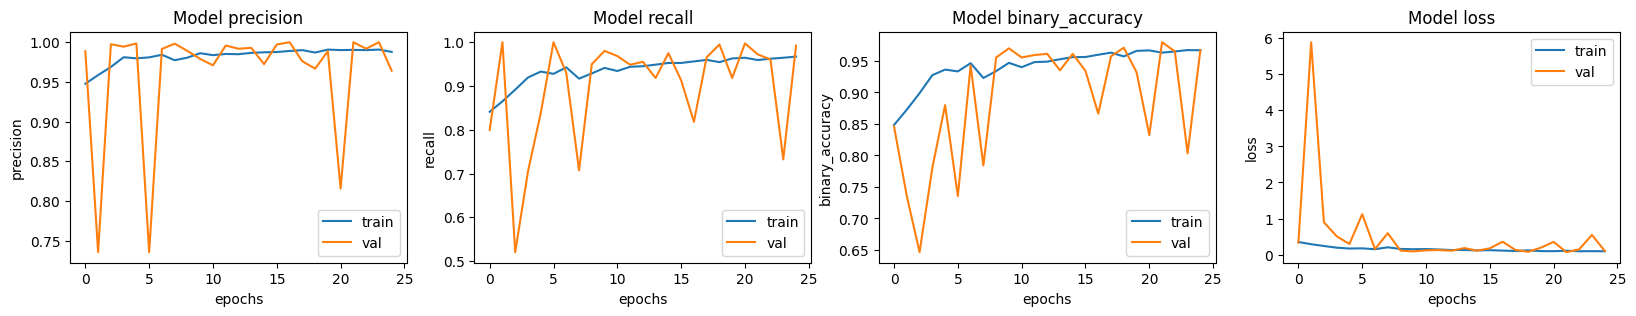

In [ ]:
#ploting the preformnce in on the traning set in diffrent epoches
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
# Defining data preprocessing function for test data
def preprocess_test_data(features, labels):
    # Cast features to float32
    features = tf.cast(features, tf.float32)
    # Ensure that images have shape (180, 180, 1)
    features = tf.expand_dims(features, axis=-1)
    return features, labels

# Apply data preprocessing to test_ds
test_ds = test_ds.map(preprocess_test_data)

In [ ]:
#evaluating the model on test set images
model.evaluate(test_ds, return_dict=True)

25/25 [==============================] - 4s 124ms/step - loss: 0.7094 - binary_accuracy: 0.7644 - precision: 0.7271 - recall: 0.9974


{'loss': 0.7094210386276245,
 'binary_accuracy': 0.7644230723381042,
 'precision': 0.7271028161048889,
 'recall': 0.9974358677864075}

<ipython-input-23-d1d8180dbbfe>:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.title(CLASS_NAMES[label[0].numpy()])


1/1 [==============================] - 1s 817ms/step
This image is 32.98 percent NORMAL
This image is 67.02 percent PNEUMONIA


<ipython-input-23-d1d8180dbbfe>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent %s" % ((100 * score), name))


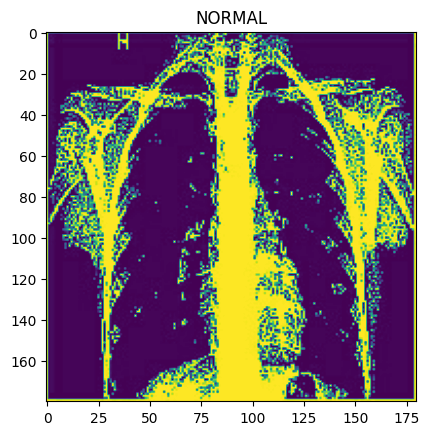

In [ ]:
import matplotlib.pyplot as plt

# Define your CLASS_NAMES if not defined already
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

for image, label in test_ds.take(1):
    #only one image in the batch, hence accessing image[0]
    plt.imshow(tf.squeeze(image[0]) / 255.0)  # Squeeze removes dimensions of size 1
    plt.title(CLASS_NAMES[label[0].numpy()])

    # Predictions
    prediction = model.predict(tf.expand_dims(image[0], axis=0))[0]  # Expand dims to make a batch of size 1
    scores = [1 - prediction, prediction]

    for score, name in zip(scores, CLASS_NAMES):
        print("This image is %.2f percent %s" % ((100 * score), name))

plt.show()


25/25 [==============================] - 2s 76ms/step


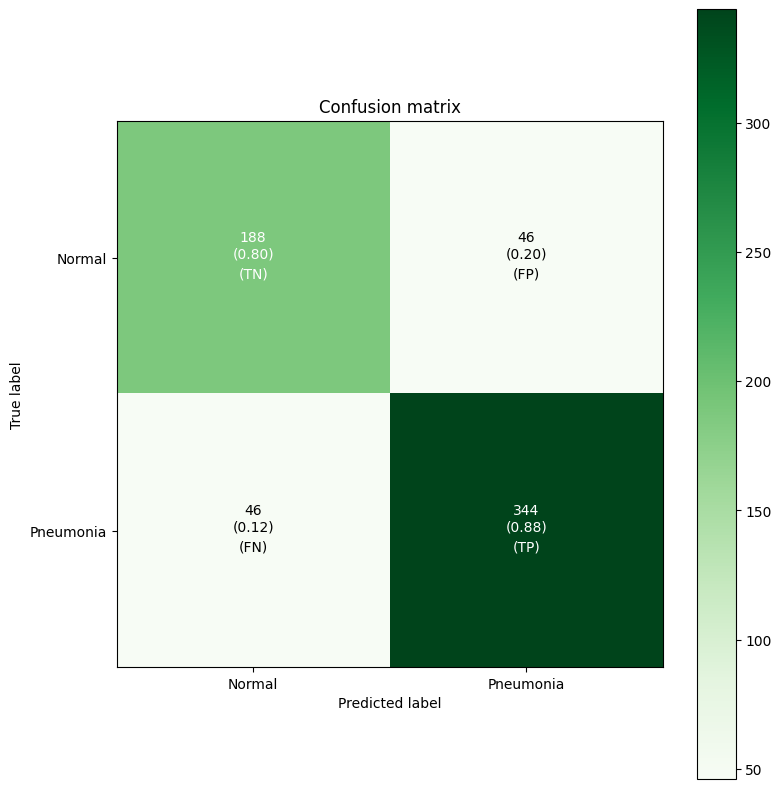

In [ ]:
#confusion matrix for one run of the model to see the results of prediction vs truth label
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the predicted and true labels for the test dataset
y_pred = model.predict(test_ds).round()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_labels = ['Normal', 'Pneumonia']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.set_title('Confusion matrix')
plt.colorbar(im, ax=ax)
tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add labels to the cells
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_norm[i, j]),
             horizontalalignment="center",
             color="white" if cm_norm[i, j] > thresh else "black")
    if i == 0 and j == 0:
        ax.text(j, i, "\n\n(TN)", va='center', ha='center', color= "white")
    elif i == 0 and j == 1:
        ax.text(j, i, "\n\n(FP)", va='center', ha='center')
    elif i == 1 and j == 0:
        ax.text(j, i, "\n\n(FN)", va='center', ha='center')
    elif i == 1 and j == 1:
        ax.text(j, i, "\n\n(TP)", va='center', ha='center',color= "white")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


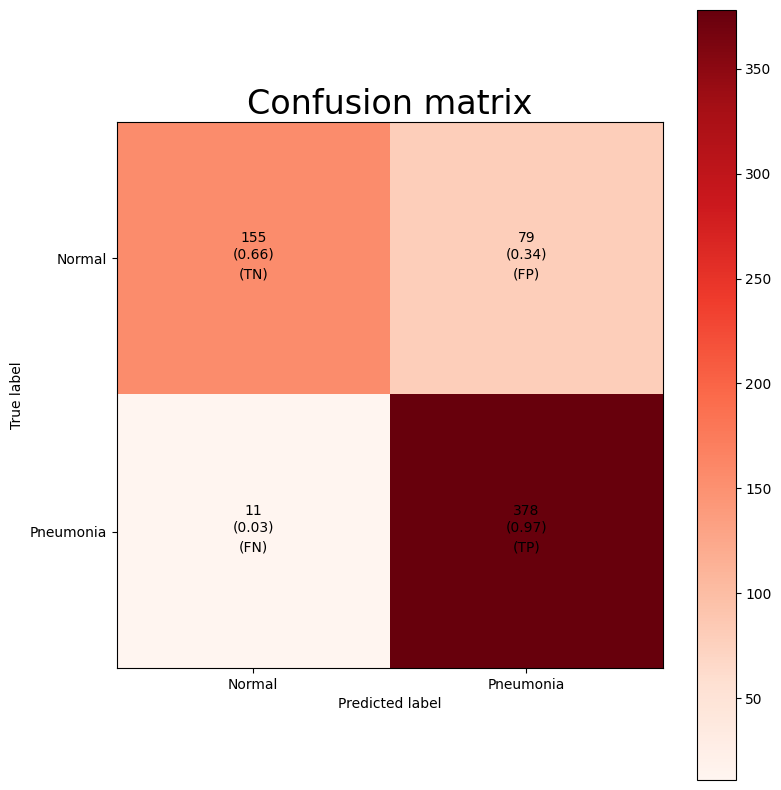

In [ ]:
#caulating manually the avarage of diffrent runings of the modle and show it
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Manually adding avraged values the confusion matrix values
# Format: [[TN, FP],
#          [FN, TP]]
cm = np.array([[155,79],
               [11, 378]])

# Define the class labels
class_labels = ['Normal', 'Pneumonia']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
ax.set_title('Confusion matrix', fontsize = 24)
plt.colorbar(im, ax=ax)
tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Normalizing the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Adding labels to the cells
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], 'd') + "\n({:.2f})".format(cm_norm[i, j]),
             horizontalalignment="center")
    if i == 0 and j == 0:
        ax.text(j, i, "\n\n(TN)", va='center', ha='center')
    elif i == 0 and j == 1:
        ax.text(j, i, "\n\n(FP)", va='center', ha='center')
    elif i == 1 and j == 0:
        ax.text(j, i, "\n\n(FN)", va='center', ha='center')
    elif i == 1 and j == 1:
        ax.text(j, i, "\n\n(TP)", va='center', ha='center')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras
from PIL import ImageFont
import matplotlib.pyplot as plt

In [ ]:
#using visual keras to show architecture wont work now because of trensformer later that is custom and not part of keras but you can see the image from before
#setting color map of each layer
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.InputLayer]['fill'] = '#FFC107'
color_map[layers.Rescaling]['fill'] = '#4CAF50'
color_map[layers.Conv2D]['fill'] = '#2196F3'
color_map[layers.MaxPooling2D]['fill'] = '#F44336'
color_map[layers.SeparableConv2D]['fill'] = '#9C27B0'
color_map[layers.BatchNormalization]['fill'] = '#5E35B1'
color_map[layers.Dropout]['fill'] = '#E91E63'
color_map[layers.Flatten]['fill'] = '#00BCD4'
color_map[layers.Dense]['fill'] = '#FF5722'

!apt-get install -y fonts-liberation
!fc-list | grep -i "liberation"

font = ImageFont.truetype("LiberationSans-Regular.ttf", 30)
#showing the figure
visualkeras.layered_view(model, legend=True, spacing=40, color_map=color_map, font = font)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-liberation is already the newest version (1:1.07.4-11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regu

TypeError: 'int' object is not iterable

In [ ]:
#ploting ROC curve for the model evlution (binary classifier)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Obtain the true labels and predicted scores for the test set
y_true = []
y_score = []

for image, label in test_ds:
    y_true.append(label.numpy())
    y_score.append(model.predict(image).ravel())

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute the false positive rate and true positive rate at various threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()